### setting up

In [1]:
# Load Necessary libraries
import os, sys
from PIL import Image
import cv2
import torch
import torchvision
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.getcwd())

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}.')

Using device: cuda.


In [4]:
# Transformations
transform_rotation = torchvision.transforms.RandomApply([
    torchvision.transforms.RandomRotation(20)
], p=0.2)

In [5]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.RandomPerspective(distortion_scale=0.1, p=0.2),
    transform_rotation,
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [6]:
transform_valid = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [9]:
# Loade Data
TRAIN_DATA_DIR = 'data/train'
VALID_DATA_DIR = 'data/val'
TEST_DATA_DIR = 'data/test'

In [10]:
BATCH_SIZE = 32

train_data = torchvision.datasets.ImageFolder(TRAIN_DATA_DIR,
                                              transform=transform_train,
                                              is_valid_file=lambda x: x.endswith('.jpg'))

valid_data = torchvision.datasets.ImageFolder(VALID_DATA_DIR,
                                              transform=transform_valid,
                                              is_valid_file=lambda x: x.endswith('.jpg'))

test_data = torchvision.datasets.ImageFolder(TEST_DATA_DIR,
                                             transform=transform_valid,
                                             is_valid_file=lambda x: x.endswith('.jpg'))

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=2)
dataloaders_dict={}
dataloaders_dict['train']= train_loader
dataloaders_dict['val']= val_loader

In [42]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


C:\Users\sento\AppData\Local\Temp\ipykernel_9056\1877047777.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  img = (img.T).detach().numpy()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


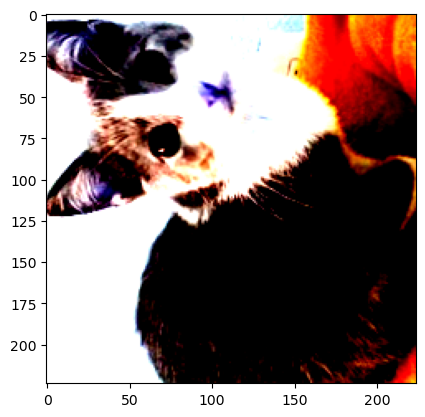

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 9


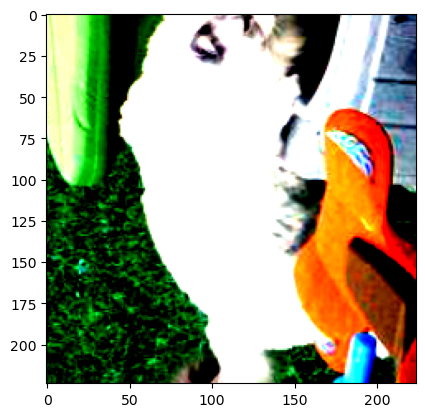

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 8


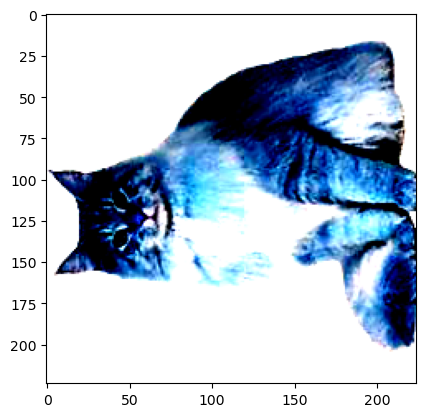

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 6


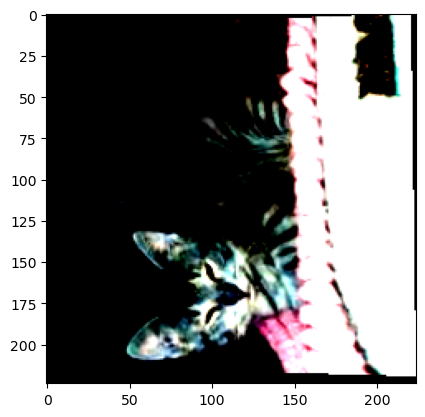

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 5


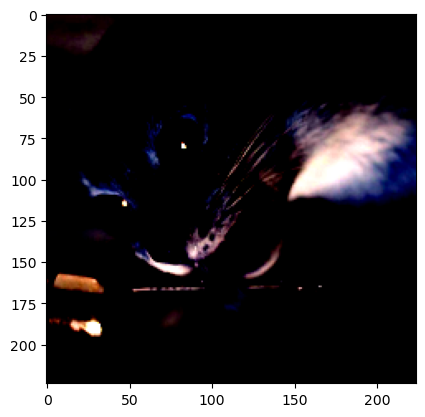

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0


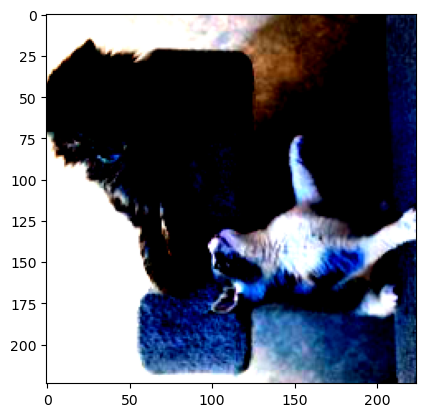

Label: 6


In [13]:
index = 0
while index < 6:
    img = train_features[index].squeeze()
    img = (img.T).detach().numpy()
    label = train_labels[index]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    print(f"Label: {label}")
    index += 1

In [14]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

### 

In [15]:
# Model

# initialize model
model = torchvision.models.resnet50(pretrained=True).to(device)

# freeze the backbone
for parameter in model.parameters():
    parameter.requires_grad = False


class ModelHead(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes):
        super(ModelHead, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden_dim // 2, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


model.fc = ModelHead(2048, 1024, 12)
model.fc.to(device)

C:\Users\sento\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sento\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ModelHead(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=12, bias=True)
)

In [18]:
# Training
MODEL_SAVE_PATH = 'checkpoints'

LEARNING_RATE = 1e-3
N_EPOCHS = 20

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


def train(model, n_epochs, criterion, optimizer, train_data_loader, valid_data_loader,
          device, model_save_path, logging_interval: int = 50):
    best_valid_f1_score = 0.0
    os.makedirs(model_save_path, exist_ok=True)

    for epoch in range(n_epochs):
        # training step
        model.train()

        for batch_idx, (batch_data, batch_labels) in enumerate(train_data_loader):
            inputs = batch_data.to(device)
            y_true = batch_labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimizer step
            y_pred = model(inputs)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % logging_interval == 0:
                print(f'Epoch: {epoch + 1}\t| Batch: {batch_idx + 1}\t| Loss: {loss}')

        # validation step
        model.eval()
        y_true = []
        y_pred = []
        for valid_data, valid_labels in valid_data_loader:
            valid_data = valid_data.to(device)
            valid_labels = valid_labels.to(device)
            with torch.no_grad():
                valid_preds = model(valid_data)
            valid_pred_labels = torch.argmax(valid_preds, dim=1)
            y_true.extend(valid_labels.detach().cpu().numpy())
            y_pred.extend(valid_pred_labels.detach().cpu().numpy())
        valid_f1_score = f1_score(y_true, y_pred, average='macro')

        if valid_f1_score > best_valid_f1_score:
            best_valid_f1_score = valid_f1_score
            torch.save(model.state_dict(),
                       os.path.join(model_save_path, 'best_checkpoint.pth'))
        print(f'Epoch {epoch + 1} F1-score: {valid_f1_score}\t| Best F1-score: {best_valid_f1_score}')
        torch.save(model.state_dict(),
                   os.path.join(model_save_path, f'epoch_{epoch + 1}_checkpoint.pth'))


train(model, N_EPOCHS, criterion, optimizer,
      train_data_loader, valid_data_loader,
      device, MODEL_SAVE_PATH)

Epoch: 1	| Batch: 50	| Loss: 1.1770488023757935
Epoch 1 F1-score: 0.5994370422325445	| Best F1-score: 0.5994370422325445
Epoch: 2	| Batch: 50	| Loss: 0.5101010799407959
Epoch 2 F1-score: 0.6920963206057774	| Best F1-score: 0.6920963206057774
Epoch: 3	| Batch: 50	| Loss: 1.0436534881591797
Epoch 3 F1-score: 0.6664533086667334	| Best F1-score: 0.6920963206057774
Epoch: 4	| Batch: 50	| Loss: 0.7847978472709656
Epoch 4 F1-score: 0.7095505692191696	| Best F1-score: 0.7095505692191696
Epoch: 5	| Batch: 50	| Loss: 0.8675841689109802
Epoch 5 F1-score: 0.7044840283091088	| Best F1-score: 0.7095505692191696
Epoch: 6	| Batch: 50	| Loss: 0.3259129524230957
Epoch 6 F1-score: 0.689641525450286	| Best F1-score: 0.7095505692191696
Epoch: 7	| Batch: 50	| Loss: 0.6099622249603271
Epoch 7 F1-score: 0.7128045579123293	| Best F1-score: 0.7128045579123293
Epoch: 8	| Batch: 50	| Loss: 0.632887065410614
Epoch 8 F1-score: 0.7131775913083435	| Best F1-score: 0.7131775913083435
Epoch: 9	| Batch: 50	| Loss: 0.421

In [19]:
# Testing
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'best_checkpoint.pth')))
model.eval()

y_true = []
y_pred = []
for test_data, test_labels in test_data_loader:
    test_data = test_data.to(device)
    test_labels = test_labels.to(device)
    with torch.no_grad():
        test_preds = model(test_data)
    test_pred_labels = torch.argmax(test_preds, dim=1)
    y_true.extend(test_labels.detach().cpu().numpy())
    y_pred.extend(test_pred_labels.detach().cpu().numpy())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80        80
           1       0.76      0.82      0.79        80
           2       0.77      0.55      0.64        80
           3       0.85      0.95      0.90        80
           4       0.85      0.64      0.73        80
           5       0.74      0.65      0.69        80
           6       0.68      0.78      0.73        80
           7       0.81      0.81      0.81        80
           8       0.60      0.74      0.66        80
           9       0.83      0.85      0.84        80
          10       0.83      0.84      0.83        80
          11       0.97      0.90      0.94        80

    accuracy                           0.78       960
   macro avg       0.79      0.78      0.78       960
weighted avg       0.79      0.78      0.78       960



In [44]:
image_path = 'data/cat_1.jpg'
image = Image.open(image_path)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
preprocessed_image = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    predictions = model(preprocessed_image)

predicted_class = torch.argmax(predictions).item()
print(predicted_class)

class_labels = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx'] 
predicted_label = class_labels[predicted_class]
print(f'Predicted class: {predicted_label}')

# 9/12

0
Predicted class: Abyssinian


<img src="data/cat_12.jpg"/>

In [43]:
!python --version

Python 3.11.5
